<a href="https://colab.research.google.com/github/NiallJeffrey/post-Newtonian/blob/master/nbody_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import time
import jax
import jax.numpy as np
from jax import jit
from jax.experimental.ode import odeint
from jax.ops import index, index_add, index_update
from jax.config import config
config.update("jax_enable_x64", True)

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
print('(GPU is often slower)')

cpu
(GPU is often slower)


In [2]:
@jit 
def acceleration_vector(r, Gm):
    return -Gm*r* (np.linalg.norm(r)**(-3))

@jit
def dydt(y,t,Gm):
  n_objects = len(Gm)
  r, v = y.reshape((2,n_objects,3))
  a = np.zeros(v.shape)

  # Loop over each i object to calculate forces
  for i in range(n_objects):
    # Sum over other j object contributions
    for j in range(n_objects):
      if i!=j: 
        a = index_add(a, index[i,:],acceleration_vector(r[i]-r[j], Gm[j]))

  return np.concatenate([v.flatten(), a.flatten()])
    

# Mock system with star, four planets and a moon

In [3]:
p1 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
p2 = np.array([1., 0., 0, 0., 3.,.0])
p3 = np.array([-2., 0., 0, 0., -2.1,.0])
p4 = np.array([0., -3., 0, 2.1, 0.,.0])
p5 = np.array([9., 0., 0, 0., 1.,.0])
m1 = p2 + np.array([0.005, 0., 0, 0., np.sqrt(1e-4/0.005),.0])
y0 = np.concatenate([p1[:3],p2[:3],p3[:3],p4[:3],p5[:3],m1[:3],p1[3:],p2[3:],p3[3:],p4[3:],p5[3:],m1[3:]])
Gm = np.array([9.,1e-4,1e-4,1e-4,1e-4,1e-6])

In [4]:
tsteps = np.linspace(0, 20, 200000)
%time jax_result_r, jax_result_v = odeint(dydt, y0, tsteps, Gm, rtol=1e-11).T.reshape(2,len(Gm),3, len(tsteps))

CPU times: user 12.2 s, sys: 258 ms, total: 12.5 s
Wall time: 12.5 s


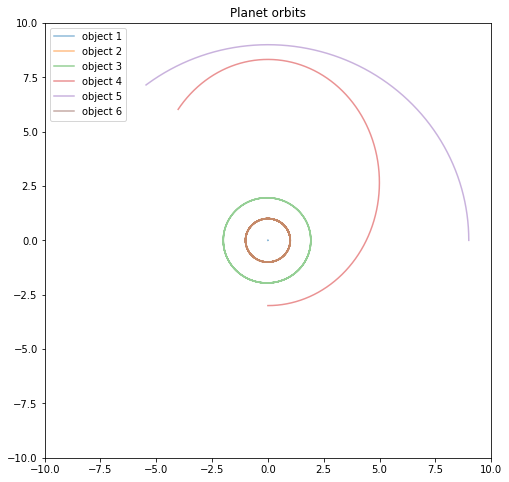

In [5]:
_ = plt.figure(figsize=(8,8)), plt.ylim(-10,10), plt.xlim(-10,10)
for i in range(len(Gm)): _ = plt.plot(jax_result_r[i,0],jax_result_r[i,1],
                                  label = 'object ' + str(i+1), alpha=0.5)
_ =  plt.title('Planet orbits'), plt.legend()

Text(0.5, 1.0, 'Moon orbit around planet')

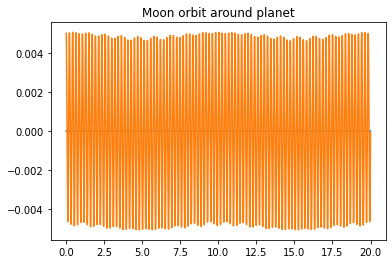

In [6]:
plt.plot(tsteps,jax_result_r[1,0]-jax_result_r[1,0])
plt.plot(tsteps,jax_result_r[5,0]-jax_result_r[1,0])
plt.title('Moon orbit around planet')

# Solar system planets (no moons)

In [7]:
%%capture
!pip install astroquery

In [8]:
from astroquery.jplhorizons import Horizons
from astropy.time import Time
from astropy import constants as const
from astropy import units as u

## Load Horizons data

In [9]:
v_array = np.zeros((10,3))
x_array = np.zeros((10,3))
masses = [0.330, 4.87,5.97 +	0.073,	0.642,	1898.,	568.,	86.8,	102,	0.0146, 1.98847e6]
Gm_planets = []
day = 86400.

for i in range(10):
  nbody_object = Horizons(id=(i+1), epochs=Time('2010-01-01').jd, id_type='id').vectors()
  print(nbody_object.columns['targetname'].data[0], masses[i]*1e24)
  Gm_planets.append(masses[i]*1e24*const.G.value)
  position = np.array([nbody_object.columns['x'].data[0],
                         nbody_object.columns['y'].data[0],
                         nbody_object.columns['z'].data[0]]) * const.au.value 
  velocity = np.array([nbody_object.columns['vx'].data[0],
                         nbody_object.columns['vy'].data[0],
                         nbody_object.columns['vz'].data[0]]) * const.au.value/day
  x_array = index_update(x_array, index[i,:],position)
  v_array = index_update(v_array, index[i,:],velocity)

y0_solar_system_planets = np.concatenate([x_array.flatten(), v_array.flatten()])
Gm_planets = np.array(Gm_planets)

Mercury Barycenter (199) 3.3e+23
Venus Barycenter (299) 4.87e+24
Earth-Moon Barycenter (3) 6.043e+24
Mars Barycenter (4) 6.42e+23
Jupiter Barycenter (5) 1.898e+27
Saturn Barycenter (6) 5.68e+26
Uranus Barycenter (7) 8.68e+25
Neptune Barycenter (8) 1.0199999999999999e+26
Pluto Barycenter (9) 1.46e+22
Sun (10) 1.98847e+30


## Evalute dynamics from start

In [10]:
tsteps = np.linspace(0, day*(365*5+1), 200000)
%time solar_planet_result_r, solar_planet_result_v = odeint(dydt, y0_solar_system_planets, tsteps, Gm_planets, rtol=1e-11).T.reshape(2,len(Gm_planets),3, len(tsteps))

CPU times: user 44.9 s, sys: 515 ms, total: 45.4 s
Wall time: 45.3 s


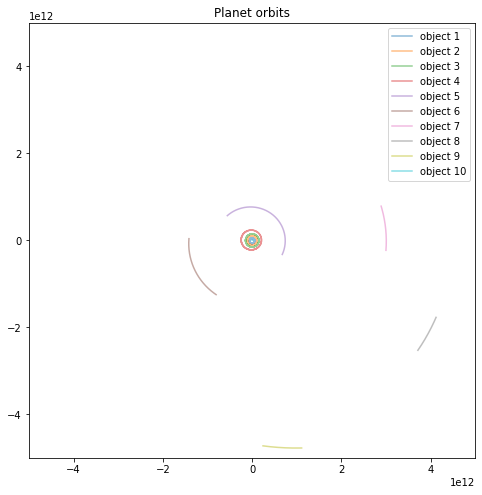

In [11]:
_ = plt.figure(figsize=(8,8)), plt.ylim(-5e12,5e12), plt.xlim(-5e12,5e12)
for i in range(len(Gm_planets)): _ = plt.plot(solar_planet_result_r[i,0],solar_planet_result_r[i,1],
                                  label = 'object ' + str(i+1), alpha=0.5)
_ =  plt.title('Planet orbits'), plt.legend()

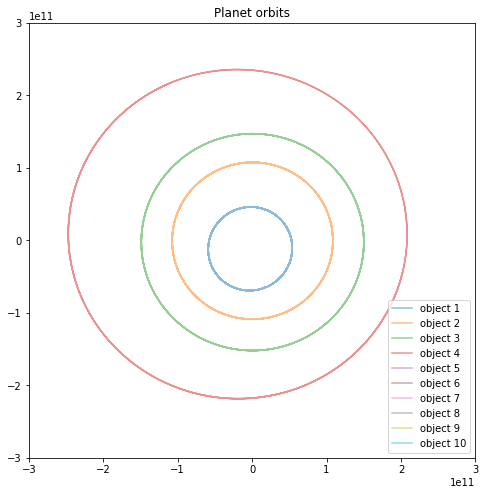

In [12]:
_ = plt.figure(figsize=(8,8)), plt.ylim(-3e11,3e11), plt.xlim(-3e11,3e11)
for i in range(len(Gm_planets)): _ = plt.plot(solar_planet_result_r[i,0] - solar_planet_result_r[-1,0],
                                              solar_planet_result_r[i,1]- solar_planet_result_r[-1,1],
                                  label = 'object ' + str(i+1), alpha=0.5)
_ =  plt.title('Planet orbits'), plt.legend()

## Load actual data for Mars

In [13]:
time_horizon = np.linspace(Time('2010-01-01').jd, Time('2015-01-01').jd, (365*5+1))

mars_orbit = np.empty((time_horizon.shape[0],3))

for i in range(len(time_horizon)):
  if i%365==0: print(i)
  mars_orbit_obj = Horizons(id=4, epochs=time_horizon[i], id_type='id').vectors()
  position = np.array([mars_orbit_obj.columns['x'].data[0],
                          mars_orbit_obj.columns['y'].data[0],
                          mars_orbit_obj.columns['z'].data[0]]) * const.au.value 
  mars_orbit = index_update(mars_orbit, index[i,:],position)
                

0
365
730
1095
1460
1825


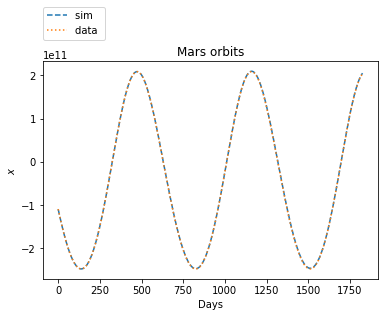

In [14]:
_ = plt.plot(tsteps/day,solar_planet_result_r[3,0,:] ,label = 'sim ', ls='--' )
_ = plt.plot(mars_orbit[:,0],label = 'data ' ,ls=':' ), plt.ylabel(r'$x$')
_ =  plt.title('Mars orbits'), plt.legend(loc=(0,1.1)), plt.xlabel('Days')